In [8]:
import seaborn as sns
import umap


from torch_geometric.nn import GCNConv, GATConv

from utilities import *
import torch_explain as te
from torch_geometric.nn import global_mean_pool, global_add_pool, global_max_pool
import numpy as np
from tqdm import tqdm

In [2]:
from torch_geometric.datasets import MNISTSuperpixels
from torch_geometric.data import DataLoader

data = MNISTSuperpixels(root='./mnist')

In [3]:
import warnings
from typing import Optional

import torch
import torch_scatter
from torch import Tensor
from torch_scatter import scatter_max, scatter_min, scatter_mul

major, minor, _ = torch.__version__.split('.', maxsplit=2)
major, minor = int(major), int(minor)
has_pytorch112 = major > 1 or (major == 1 and minor >= 12)

if has_pytorch112:  # pragma: no cover

    warnings.filterwarnings('ignore', '.*is in beta and the API may change.*')


    def broadcast(src: Tensor, ref: Tensor, dim: int) -> Tensor:
        size = [1] * ref.dim()
        size[dim] = -1
        return src.view(size).expand_as(ref)


    def scatter(src: Tensor, index: Tensor, dim: int = 0,
                dim_size: Optional[int] = None, reduce: str = 'sum') -> Tensor:
        r"""Reduces all values from the :obj:`src` tensor at the indices
        specified in the :obj:`index` tensor along a given dimension
        :obj:`dim`. See the `documentation
        <https://pytorch-scatter.readthedocs.io/en/latest/functions/
        scatter.html>`_ of :obj:`torch-scatter` for more information.

        Args:
            src (torch.Tensor): The source tensor.
            index (torch.Tensor): The index tensor.
            dim (int, optional): The dimension along which to index.
                (default: :obj:`0`)
            dim_size (int, optional): The size of the output tensor at
                dimension :obj:`dim`. If set to :obj:`None`, will create a
                minimal-sized output tensor according to
                :obj:`index.max() + 1`. (default: :obj:`None`)
            reduce (str, optional): The reduce operation (:obj:`"sum"`,
                :obj:`"mean"`, :obj:`"mul"`, :obj:`"min"` or :obj:`"max"`).
                (default: :obj:`"sum"`)
        """
        if index.dim() != 1:
            raise ValueError(f"The `index` argument must be one-dimensional "
                             f"(got {index.dim()} dimensions)")

        dim = src.dim() + dim if dim < 0 else dim

        if dim < 0 or dim >= src.dim():
            raise ValueError(f"The `dim` argument must lay between 0 and "
                             f"{src.dim() - 1} (got {dim})")

        if dim_size is None:
            dim_size = int(index.max()) + 1 if index.numel() > 0 else 0

        # For now, we maintain various different code paths, based on whether
        # the input requires gradients and whether it lays on the CPU/GPU.
        # For example, `torch_scatter` is usually faster than
        # `torch.scatter_reduce` on GPU, while `torch.scatter_reduce` is faster
        # on CPU.
        # `torch.scatter_reduce` has a faster forward implementation for
        # "min"/"max" reductions since it does not compute additional arg
        # indices, but is therefore way slower in its backward implementation.
        # More insights can be found in `test/utils/test_scatter.py`.

        size = list(src.size())
        size[dim] = dim_size

        # For "sum" and "mean" reduction, we make use of `scatter_add_`:
        if reduce == 'sum' or reduce == 'add':
            index = broadcast(index, src, dim)
            return src.new_zeros(size).scatter_add_(dim, index, src)

        if reduce == 'mean':
            count = src.new_zeros(dim_size)
            count.scatter_add_(0, index, src.new_ones(src.size(dim)))
            count = count.clamp_(min=1)

            index = broadcast(index, src, dim)
            out = src.new_zeros(size).scatter_add_(dim, index, src)

            return out / broadcast(count, out, dim)

        # For "min" and "max" reduction, we prefer `scatter_reduce_` on CPU or
        # in case the input does not require gradients:
        if reduce == 'min' or reduce == 'max':
            if not src.is_cuda or not src.requires_grad:
                index = broadcast(index, src, dim)
                return src.new_zeros(size).scatter_reduce_(
                    dim, index, src, reduce=f'a{reduce}', include_self=False)

            if reduce == 'min':
                return scatter_min(src, index, dim, dim_size=dim_size)[0]
            else:
                return scatter_max(src, index, dim, dim_size=dim_size)[0]

        # For "mul" reduction, we prefer `scatter_reduce_` on CPU:
        if reduce == 'mul':
            if not src.is_cuda:
                index = broadcast(index, src, dim)
                # We initialize with `one` here to match `scatter_mul` output:
                return src.new_ones(size).scatter_reduce_(
                    dim, index, src, reduce='prod', include_self=True)
            else:
                return scatter_mul(src, index, dim, dim_size=dim_size)

        raise ValueError(f"Encountered invalid `reduce` argument '{reduce}'")

else:

    def scatter(src: Tensor, index: Tensor, dim: int = 0,
                dim_size: Optional[int] = None, reduce: str = 'sum') -> Tensor:
        r"""Reduces all values from the :obj:`src` tensor at the indices
        specified in the :obj:`index` tensor along a given dimension
        :obj:`dim`. See the `documentation
        <https://pytorch-scatter.readthedocs.io/en/latest/functions/
        scatter.html>`_ of :obj:`torch-scatter` for more information.

        Args:
            src (torch.Tensor): The source tensor.
            index (torch.Tensor): The index tensor.
            dim (int, optional): The dimension along which to index.
                (default: :obj:`0`)
            dim_size (int, optional): The size of the output tensor at
                dimension :obj:`dim`. If set to :obj:`None`, will create a
                minimal-sized output tensor according to
                :obj:`index.max() + 1`. (default: :obj:`None`)
            reduce (str, optional): The reduce operation (:obj:`"sum"`,
                :obj:`"mean"`, :obj:`"mul"`, :obj:`"min"` or :obj:`"max"`).
                (default: :obj:`"sum"`)
        """
        return torch_scatter.scatter(src, index, dim, dim_size=dim_size,
                                     reduce=reduce)

from typing import Optional

from torch import Tensor


def global_mul_pool(x: Tensor, batch: Optional[Tensor],
                    size: Optional[int] = None) -> Tensor:
    r"""Returns batch-wise graph-level-outputs by adding node features
    across the node dimension, so that for a single graph
    :math:`\mathcal{G}_i` its output is computed by

    .. math::
        \mathbf{r}_i = \sum_{n=1}^{N_i} \mathbf{x}_n.

    Functional method of the
    :class:`~torch_geometric.nn.aggr.SumAggregation` module.

    Args:
        x (torch.Tensor): Node feature matrix
            :math:`\mathbf{X} \in \mathbb{R}^{(N_1 + \ldots + N_B) \times F}`.
        batch (torch.Tensor, optional): The batch vector
            :math:`\mathbf{b} \in {\{ 0, \ldots, B-1\}}^N`, which assigns
            each node to a specific example.
        size (int, optional): The number of examples :math:`B`.
            Automatically calculated if not given. (default: :obj:`None`)
    """
    dim = -1 if x.dim() == 1 else -2

    if batch is None:
        return x.sum(dim=dim, keepdim=x.dim() <= 2)
    size = int(batch.max().item() + 1) if size is None else size
    return scatter(x, batch, dim=dim, dim_size=size, reduce='mul')


class Pool_mul(torch.nn.Module):
    def __init__(self):
        super(Pool_mul, self).__init__()

    def forward(self, x, batch):
        return global_mul_pool(x, batch)


class Pool_sum(torch.nn.Module):
    def __init__(self):
        super(Pool_sum, self).__init__()

    def forward(self, x, batch):
        return global_add_pool(x, batch)

In [4]:
class Pool_max(torch.nn.Module):
    def __init__(self):
        super(Pool_max, self).__init__()

    def forward(self, x, batch):
        return global_max_pool(x, batch)

In [108]:
class GCN(nn.Module):
    def __init__(self, num_in_features, num_hidden_features,
                 cluster_encoding_size, num_classes):
        super(GCN, self).__init__()

        self.conv0 = GCNConv(num_in_features, num_hidden_features)
        self.conv1 = GCNConv(num_hidden_features, num_hidden_features)
        self.conv2 = GCNConv(num_hidden_features, num_hidden_features)
        self.conv3 = GCNConv(num_hidden_features, cluster_encoding_size)

        self.pool = Pool()
        self.pool_max = Pool_max()
        self.pool2 = Pool_mul()
        self.pool3 = Pool_sum()

        # linear layers
        self.lens = torch.nn.Sequential(te.nn.EntropyLinear(cluster_encoding_size, 1, n_classes=num_classes))
        self.linear = nn.Linear(2*cluster_encoding_size, num_classes)
        self.euclidian = nn.PairwiseDistance(p=2)

    def forward(self, x, edge_index, batch, epoch, table, indexes=None):
        x = self.conv0(x, edge_index)
        x = F.leaky_relu(x)

        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)

        x = self.conv2(x, edge_index)
        x = F.leaky_relu(x)

        x = self.conv3(x, edge_index)
        x = F.leaky_relu(x)

        x = x.squeeze()

        self.gnn_node_embedding = x
        x = F.softmax(x, dim=-1)
        x = torch.div(x, torch.max(x, dim=-1)[0].unsqueeze(1))
        self.gnn_node_concepts = x

        # if epoch < 100:
        #     x = self.pool(x, batch)
        # else:
        #     x = self.pool2(x, batch)
        # x = torch.cat((self.pool(x, batch),
        #                self.pool_max(x, batch),
        #                self.pool2(x, batch),
        #                self.pool3(x, batch)
        #                ), dim=1)

        x = self.pool(x, batch)

        if self.training:
            euclidian_d = self.euclidian(x[indexes], table[indexes])

        else:
            euclidian_d = self.euclidian(x, table)

        # x = (x > 0.5) + 0
        # x = self.pool3(x, batch)
        # x = torch.clamp(x, max=1)

        # x = F.softmax(x, dim=-1)
        # x = torch.div(x, torch.max(x, dim=-1)[0].unsqueeze(1))
        self.gnn_graph_concepts = x

        x = self.lens(x)
        x = x.squeeze(-1)
        return self.gnn_graph_concepts, x, euclidian_d

model_type = GCN

In [109]:
def register_hooks(model):
    # register hooks to extract activations
    if isinstance(model, Mutag_GCN) or isinstance(model, Reddit_GCN):
        for name, m in model.named_modules():
            if isinstance(m, nn.Linear):
                m.register_forward_hook(get_activation(f"{name}"))
            if isinstance(m, Pool):
                m.register_forward_hook(get_activation(f"{name}"))
            if isinstance(m, Pool_mul) or isinstance(m, Pool_sum):
                m.register_forward_hook(get_activation(f"{name}"))

    else:
        for name, m in model.named_modules():
            if isinstance(m, GCNConv) or isinstance(m, DenseGCNConv):
                m.register_forward_hook(get_activation(f"{name}"))
            if isinstance(m, nn.Linear):
                m.register_forward_hook(get_activation(f"{name}"))
            if isinstance(m, Pool):
                m.register_forward_hook(get_activation(f"{name}"))

    return model

def test_graph_class(model, dataloader, tab_dataset):
    # enter evaluation mode
    correct = 0
    for index, data in enumerate(dataloader):
        _, out, euclidian = model(data.x, data.edge_index, data.batch, 101, tab_dataset[index])
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    euclidian_d_mean = torch.mean(euclidian)
    return correct / len(dataloader.dataset), euclidian_d_mean

def train_graph_class(model, train_loader, test_loader, tab_train_dataset, tab_test_dataset,
                      anchors, epochs, lr, n_classes, path):
    # register hooks to track activation
    model = register_hooks(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.BCEWithLogitsLoss()

    # list of accuracies
    train_accuracies, test_accuracies, train_loss, test_loss = list(), list(), list(), list()

    for epoch in range(epochs):
        model.train()

        running_loss = 0
        num_batches = 0
        train_concepts = []
        for index, data in enumerate(train_loader):
            model.train()

            optimizer.zero_grad()

            concepts, out, euclidian = model(data.x, data.edge_index, data.batch, epoch,
                                  tab_train_dataset[index], anchors[index])
            train_concepts += [concepts]
            # calculate loss
            one_hot = torch.nn.functional.one_hot(data.y, num_classes=n_classes).type_as(out)

            loss = criterion(out, one_hot) + 0.1*torch.mean(euclidian).item()
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)

            running_loss += loss.item()
            num_batches += 1

            optimizer.step()

        # get accuracy
        train_acc, euclidian_train = test_graph_class(model, train_loader, tab_train_dataset)
        test_acc, euclidian_test = test_graph_class(model, test_loader, tab_test_dataset)

        # add to list and print
        model.eval()
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        # get testing loss
        test_running_loss = 0
        test_num_batches = 0
        test_concepts = []
        for index, data in enumerate(test_loader):
            concepts, out, euclidian = model(data.x, data.edge_index, data.batch, epoch,
                                  tab_test_dataset[index])
            test_concepts += [concepts]
            one_hot = torch.nn.functional.one_hot(data.y, num_classes=n_classes).type_as(out)

            test_running_loss += criterion(out, one_hot).item() + torch.mean(euclidian).item()
            test_num_batches += 1

        train_loss.append(running_loss / num_batches)
        test_loss.append(test_running_loss / test_num_batches)
        print(('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Test Acc: {:.5f} '+
              'Train Euclidean: {:.5f}, Test Euclidean: {:.5f}').
              format(epoch, loss.item(), train_acc, test_acc,
                    euclidian_train, euclidian_test), end = "\r")

        if train_acc >= 0.85 and test_acc >= 0.85:
            break

    # plut accuracy graph
    plt.plot(train_accuracies, label="Train accuracy")
    plt.plot(test_accuracies, label="Validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='upper right')
    plt.show()

    plt.plot(train_loss, label="Train loss")
    plt.plot(test_loss, label="Test loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='upper right')
    plt.show()

    torch.save(model.state_dict(), os.path.join(path, "model.pkl"))

    with open(os.path.join(path, "activations.txt"), 'wb') as file:
        pickle.dump(activation_list, file)

    concepts = torch.cat((torch.cat(train_concepts, dim=0), torch.cat(test_concepts, dim=0)), dim=0)
    return concepts

In [110]:
def prepare_real_data(graphs, train_split, batch_size):
    graphs = graphs.shuffle()

    to_use_index = int(len(graphs) * 0.15)
    dataset = graphs[:to_use_index]

    train_idx = int(to_use_index * train_split)
    train_set = dataset[:train_idx]
    test_set = dataset[train_idx:]

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

In [19]:
train_loader, test_loader = prepare_real_data(data, 0.8, 500)

60000
7200
1800


In [49]:
cluster_encoding_size = 64
num_hidden_units = 64

epochs = 100
lr = 0.005

In [111]:
paths = prepare_output_paths('MNIST', cluster_encoding_size)

model = model_type(data.num_node_features, num_hidden_units,
                   cluster_encoding_size, data.num_classes)

model.apply(weights_init)
concepts = train_graph_class(model, train_loader, test_loader, epochs, lr,
                             10, paths['base'])

TypeError: train_graph_class() missing 3 required positional arguments: 'lr', 'n_classes', and 'path'

In [57]:
train_dataset = []
for item in train_loader:
    for i in range(item['y'].shape[0]):
        tmp_x = item['x'][i*75:(i+1)*75]
        tmp_x = tmp_x.reshape(tmp_x.shape[-1], tmp_x.shape[-2])
        train_dataset += [tmp_x, item['y'][i]]



In [58]:
train_dataset

[tensor([[0.5412, 0.9745, 0.6765, 0.1765, 0.3137, 0.5020, 0.4980, 0.4784, 0.2444,
          0.2745, 0.9634, 0.9961, 0.4209, 0.5412, 0.8588, 0.9333, 0.9072, 0.9961,
          0.9039, 0.2745, 0.1490, 0.1725, 0.7363, 0.8706, 0.9216, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000]]),
 tensor(1),
 tensor([[0.1399, 0.6676, 0.1712, 0.5176, 0.5475, 0.6928, 0.6765, 0.6693, 0.5725,
          0.5325, 0.6801, 0.4889, 0.5856, 0.8611, 0.6147, 0.1490, 0.5975, 0.8275,
          0.6659, 0.6425, 0.7245, 0.8125, 0.8020, 0.7027, 0.3490, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [64]:
print(item['edge_index'])

tensor([[    0,     0,     0,  ..., 14999, 14999, 14999],
        [    4,     7,     8,  ..., 14995, 14996, 14998]])


In [12]:
from tqdm import tqdm

import time
import pickle
import multiprocessing

import numpy as np
import scipy as sp
from skimage.segmentation import slic, mark_boundaries
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST

NP_TORCH_FLOAT_DTYPE = np.float32
NP_TORCH_LONG_DTYPE = np.int64

NUM_FEATURES = 3
NUM_CLASSES = 10

def split_dataset(labels, valid_split=0.1):
    idx = np.random.permutation(len(labels))
    valid_idx = []
    train_idx = []
    label_count = [0 for _ in range(1+max(labels))]
    valid_count = [0 for _ in label_count]

    for i in idx:
        label_count[labels[i]] += 1


    for i in idx:
        l = labels[i]
        if valid_count[l] < label_count[l]*valid_split:
            valid_count[l] += 1
            valid_idx.append(i)
        else:
            train_idx.append(i)
    return train_idx, valid_idx

def get_graph_from_image(image,desired_nodes=75):
    # load the image and convert it to a floating point data type
    segments = slic(image, n_segments=desired_nodes, slic_zero = True)
    asegments = np.array(segments)

    num_nodes = np.max(asegments)
    nodes = {
        node: {
            "rgb_list": [],
            "pos_list": []
        } for node in range(1, num_nodes+1)
    }

    height = image.shape[0]
    width = image.shape[1]

    for y in range(height):
        for x in range(width):
            node = asegments[y,x]
            rgb = image[y,x,:]
            pos = np.array([float(x)/width,float(y)/height])
            nodes[node]["rgb_list"].append(rgb)
            nodes[node]["pos_list"].append(pos)
        #end for
    #end for
    G = nx.Graph()

    for node in nodes:
        nodes[node]["rgb_list"] = np.stack(nodes[node]["rgb_list"])
        nodes[node]["pos_list"] = np.stack(nodes[node]["pos_list"])
        # rgb

        rgb_mean = np.mean(nodes[node]["rgb_list"], axis=0)
        #rgb_std = np.std(nodes[node]["rgb_list"], axis=0)
        #rgb_gram = np.matmul( nodes[node]["rgb_list"].T, nodes[node]["rgb_list"] ) / nodes[node]["rgb_list"].shape[0]
        # Pos
        pos_mean = np.mean(nodes[node]["pos_list"], axis=0)
        #pos_std = np.std(nodes[node]["pos_list"], axis=0)
        #pos_gram = np.matmul( nodes[node]["pos_list"].T, nodes[node]["pos_list"] ) / nodes[node]["pos_list"].shape[0]
        # Debug

        features = np.concatenate(
          [
            np.reshape(rgb_mean, -1),
            #np.reshape(rgb_std, -1),
            #np.reshape(rgb_gram, -1),
            np.reshape(pos_mean, -1),
            #np.reshape(pos_std, -1),
            #np.reshape(pos_gram, -1)
          ]
        )
        G.add_node(node-1, features = list(features))
    #end

    # From https://stackoverflow.com/questions/26237580/skimage-slic-getting-neighbouring-segments
    segments_ids = np.unique(segments)

    # centers
    centers = np.array([np.mean(np.nonzero(segments==i),axis=1) for i in segments_ids])

    vs_right = np.vstack([segments[:,:-1].ravel(), segments[:,1:].ravel()])
    vs_below = np.vstack([segments[:-1,:].ravel(), segments[1:,:].ravel()])
    bneighbors = np.unique(np.hstack([vs_right, vs_below]), axis=1)

    # Adjacency loops
    for i in range(bneighbors.shape[1]):
        if bneighbors[0,i] != bneighbors[1,i]:
            G.add_edge(bneighbors[0,i]-1,bneighbors[1,i]-1)

    # Self loops
    for node in nodes:
        G.add_edge(node-1,node-1)

    n = len(G.nodes)
    m = len(G.edges)
    h = np.zeros([n,NUM_FEATURES]).astype(NP_TORCH_FLOAT_DTYPE)
    edges = np.zeros([2*m,2]).astype(NP_TORCH_LONG_DTYPE)
    for e,(s,t) in enumerate(G.edges):
        edges[e,0] = s
        edges[e,1] = t

        edges[m+e,0] = t
        edges[m+e,1] = s
    #end for
    for i in G.nodes:
        h[i-1,:] = G.nodes[i]["features"]
    #end for
    del G
    return h, edges

print("Reading dataset")
dset = MNIST("./mnist",download=False)
imgs = dset.data.unsqueeze(-1).numpy().astype(np.float64)[:10000]
labels = dset.targets[:10000].numpy()
train_idx, valid_idx = map(np.array, split_dataset(labels))


print("Processing images into graphs...", end="")
ptime = time.time()
graphs = list(map(get_graph_from_image, imgs))

del imgs
ptime = time.time() - ptime
print(" Took {ptime}s".format(ptime=ptime))

Reading dataset
Processing images into graphs... Took 60.72635221481323s


In [13]:
train_mask = torch.Tensor([True if i in train_idx else False for i in range(len(labels))]).bool()
test_mask = torch.Tensor([True if i in valid_idx else False for i in range(len(labels))]).bool()

In [14]:
batch_size = 500

In [18]:
from torch.utils.data import Dataset

In [19]:
class MNIST_SUPERPIXELS(Dataset):
     def __init__(self, graphs, labels, mask):
         super(Dataset, self).__init__()
         self.nodes = torch.Tensor([ele[0] for ele in graphs])[mask]
         self.edges = torch.Tensor([ele[1] for ele in graphs])[mask].long()
         self.labels = torch.Tensor(labels)[mask].long()

     def __len__(self):
         return self.labels.shape[0]

     def __getitem__(self, index):
        return Data(x=self.nodes[index],
                    edge_index=torch.transpose(self.edges[index], 0, 1),
                    y=self.labels[index])

In [20]:
batch_size = 100

In [21]:
train = MNIST_SUPERPIXELS(graphs, labels, train_mask)
test = MNIST_SUPERPIXELS(graphs, labels, test_mask)

<ipython-input-19-6ca54828b94c>:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  self.nodes = torch.Tensor([ele[0] for ele in graphs])[mask]


In [22]:
train[0]

Data(edge_index=[2, 450], x=[81, 3], y=5)

In [23]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [66]:
indexes_train

array([ 443, 6443, 5448, ..., 5774, 6780, 7079])

In [74]:
def anchor_index_list(trainloader, k):
    result = []
    for i in trainloader:
        anchors = np.random.choice(i['y'].shape[0], size=int(k/len(trainloader)), replace=False)
        result += [anchors]
    return result

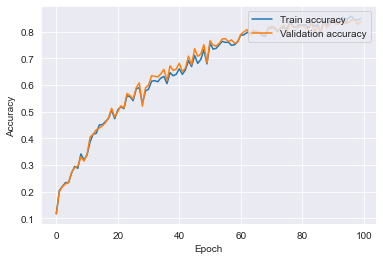

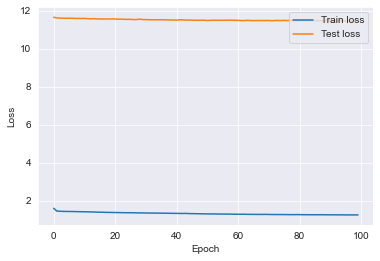

In [115]:
cluster_encoding_size = 64
num_hidden_units = 64
epochs = 100
lr = 0.001
paths = prepare_output_paths('MNIST', cluster_encoding_size)

model = model_type(NUM_FEATURES, num_hidden_units,
                   cluster_encoding_size, data.num_classes)

n_anchors = 1000
indexes = anchor_index_list(train_loader, n_anchors)
model.apply(weights_init)
concepts = train_graph_class(model, train_loader, test_loader, tab_train_dataset,
                             tab_test_dataset, indexes, epochs, lr*10,
                             10, paths['base'])

/Users/gabri/GCExplainer/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gabri/GCExplainer/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


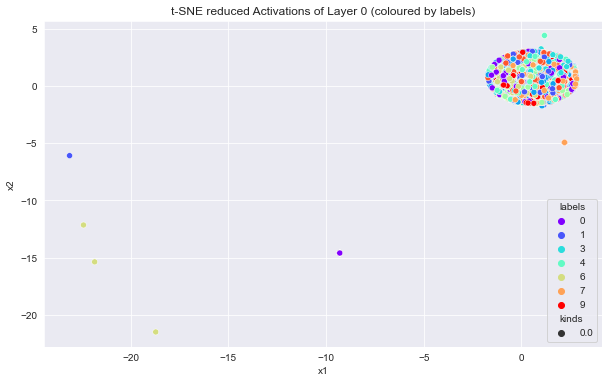

In [117]:
layer_num = 0
y_g = [i.item() for i in tabular_df["y"]]
tsne_model = TSNE(n_components=2)
d = tsne_model.fit_transform((concepts.detach().numpy() > 0.5))
plot_activation_space_markers(d, y_g, "t-SNE reduced", layer_num, paths['TSNE'], "(coloured by labels)")

In [38]:
def test_graph_class_activation(model, dataloader_train, dataloader_test):
    # enter evaluation mode
    correct = 0
    hidden = ""
    for data in dataloader_train:
        out = model(data.x, data.edge_index, data.batch, 101)
        if hidden == "":
            hidden = torch.clamp(activation_list['pool'], max=1)
        else:
            hidden = torch.cat((hidden, torch.clamp(activation_list['pool'], max=1)), 0)

    for data in dataloader_test:
        out = model(data.x, data.edge_index, data.batch, 101)
        hidden = torch.cat((hidden, torch.clamp(activation_list['pool'], max=1)), 0)
    return hidden


hidden_graph = test_graph_class_activation(model, train_loader, test_loader)

In [77]:
tab_train_dataset = []
tab_test_dataset = []

for index, i in enumerate(train_loader):
    tab_train_dataset += [tab_activation_train[index*batch_size:index*batch_size+i['y'].shape[0]]]

for index, i in enumerate(test_loader):
    tab_test_dataset += [tab_activation_test[index*batch_size:index*batch_size+i['y'].shape[0]]]


In [54]:
class MLP(torch.nn.Module):

    def __init__(self, input_size, hidden_size, anchors, n_classes, name):
        super(MLP, self).__init__()
        self.name = name
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.n_classes  = n_classes
        self.anchors = anchors
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size*5)
        self.fc3 = torch.nn.Linear(self.hidden_size*5, self.hidden_size*5)
        self.fc4 = torch.nn.Linear(self.hidden_size*5, self.hidden_size)
        self.fc5 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.lens = torch.nn.Sequential(te.nn.EntropyLinear(self.hidden_size,
                                                            1, n_classes=num_classes))
        self.euclidian = nn.PairwiseDistance(p=2)

    def forward(self, x, graph):
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        x = F.tanh(x)
        x = self.fc3(x)
        x = F.tanh(x)
        x = self.fc4(x)
        x = F.tanh(x)
        x = self.fc5(x)
        if self.training:
            # euclidian_d = self.euclidian(x[self.anchors], graph[self.anchors])
            euclidian_d = 0
        else:
            # euclidian_d = self.euclidian(x, graph)
            euclidian_d = 0
        #x = F.leaky_relu(x)
        x = F.softmax(x, dim=-1)
        x = torch.div(x, torch.max(x, dim=-1)[0].unsqueeze(1))
        concepts = x

        x = self.lens(x)

        return concepts, x.squeeze(-1), euclidian_d


def test_mlp(model, node_data_x, graph, node_data_y, mask):
    # enter evaluation mode
    model.eval()
    correct = 0
    _, pred, euclidian = model(node_data_x, graph)
    pred = pred.max(dim=1)[1]

    correct += pred[mask].eq(node_data_y[mask]).sum().item()
    # euclidian_d_mean = torch.mean(euclidian[mask])
    euclidian_d_mean = 0
    return correct / (len(node_data_y[mask])), euclidian_d_mean

def train_mlp(model, data, train_mask, test_mask, epochs, lr, path):
    model = register_hooks(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # list of accuracies
    train_accuracies, test_accuracies, train_losses, test_losses = list(), list(), list(), list()

    # get data
    x = torch.Tensor(list(pd.DataFrame(list(data['x'])).to_numpy()))
    graph = torch.Tensor(list(pd.DataFrame(list(data['graph'])).to_numpy()))
    y = torch.Tensor(list(data[["y"]].to_numpy())).long().squeeze(dim=-1)

    # iterate for number of epochs
    for epoch in range(epochs):
        # set mode to training
        model.train()
        optimizer.zero_grad()

        # input data
        concepts, out, euclidian = model(x, graph)
        # calculate loss
        #loss = F.cross_entropy(out[train_mask], y[train_mask]) + torch.mean(euclidian[train_mask])
        loss = F.cross_entropy(out[train_mask], y[train_mask]) # + torch.mean(euclidian)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            #test_loss = F.cross_entropy(out[test_mask], y[test_mask]) + torch.mean(euclidian[test_mask])
            test_loss = F.cross_entropy(out[test_mask], y[test_mask]) # + torch.mean(euclidian)

            # get accuracy
            model.eval()
            train_acc, euclidian_train = test_mlp(model, x, graph, y, train_mask)
            test_acc, euclidian_test = test_mlp(model, x, graph, y, test_mask)

        ## add to list and print
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        train_losses.append(loss.item())
        test_losses.append(test_loss.item())

        print(('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Test Acc: {:.5f} '+
              'Train Euclidean: {:.5f}, Test Euclidean: {:.5f}').
              format(epoch, loss.item(), train_acc, test_acc,
                    euclidian_train, euclidian_test), end = "\r")
        # plut accuracy graph
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(test_accuracies, label="Testing Accuracy")
    plt.title(f"Accuracy of {model.name} Model during Training")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='upper right')
    plt.savefig(os.path.join(path, f"model_accuracy_plot.png"))
    plt.show()

    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Testing Loss")
    plt.title(f"Loss of {model.name} Model during Training")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='upper right')
    plt.savefig(os.path.join(path, f"model_loss_plot.png"))
    plt.show()

    # save model
    torch.save(model.state_dict(), os.path.join(path, "model.pkl"))

    with open(os.path.join(path, "activations.txt"), 'wb') as file:
        pickle.dump(activation_list, file)

    return concepts

In [55]:
def anchor_index(size, k):
    anchors = np.random.choice(size, size=k, replace=False)
    return anchors

tensor([2., 3.])

/Users/gabri/GCExplainer/lib/python3.9/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


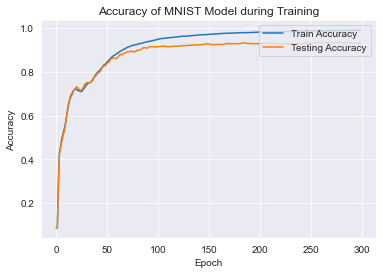

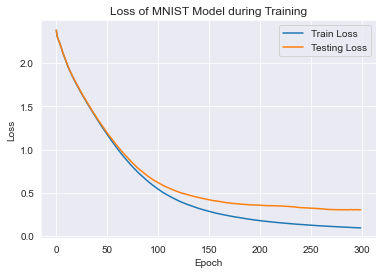

In [56]:
epochs = 300
torch.manual_seed(42)
num_anchor = 2000
num_classes = 10
indexes_train = anchor_index(np.array(range(hidden_graph.shape[0]))[train_mask],
                             num_anchor)
mlp = MLP(len(tabular_df['x'][0]), num_hidden_units, indexes_train, num_classes,
          'MNIST')
concepts_mlp = train_mlp(mlp, tabular_df, train_mask, test_mask, epochs, lr, paths['base'])

In [58]:
tab_activation = activation_list['fc5']
tab_activation_train = tab_activation[train_mask]
tab_activation_test = tab_activation[test_mask]

In [34]:
def plot_activation_space_markers(data, labels, activation_type, layer_num, path, note="", naming_help=""):
    rows = len(data)
    df = pd.DataFrame(data, columns=['x1', 'x2'])
    df['labels'] = labels
    # kinds = np.concatenate((np.zeros(int(data.shape[0] / 2)), np.ones(int(data.shape[0] / 2))), axis=0)
    kinds = np.zeros(int(data.shape[0]))
    df['kinds'] = kinds
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title(f"{activation_type} Activations of Layer {layer_num} {note}")
    scatter = sns.scatterplot(df, x='x1', y='x2', hue='labels', style='kinds', palette='rainbow')
    #scatter = ax.scatter(data[:,0], data[:,1], c=labels, cmap='rainbow')

    plt.savefig(os.path.join(path, f"{layer_num}_layer{naming_help}.png"))
    plt.show()


/Users/gabri/GCExplainer/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gabri/GCExplainer/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


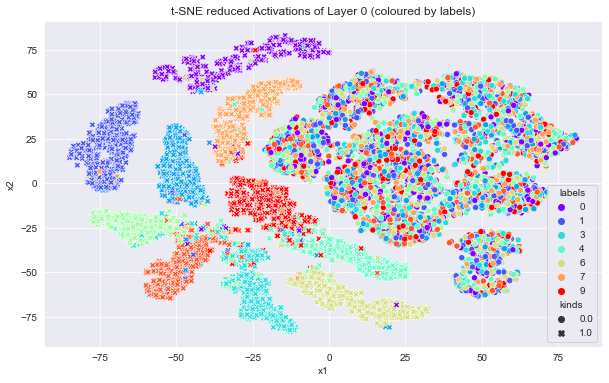

In [216]:
y_g = [i.item() for i in tabular_df["y"]]
layer_num = 0
activation1 = hidden_graph
activation2 = torch.squeeze(activation_list['fc5'])
c = np.concatenate((activation1, activation2), axis=0)
d_labels = np.concatenate((y_g, y_g), axis=0)
tsne_model = TSNE(n_components=2)
d = tsne_model.fit_transform(c)
plot_activation_space_markers(d, d_labels, "t-SNE reduced", layer_num, paths['TSNE'], "(coloured by labels)")

/Users/gabri/GCExplainer/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gabri/GCExplainer/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


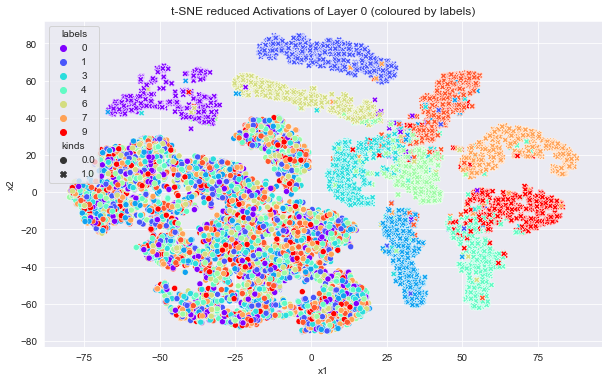

In [221]:
layer_num = 0
c = np.concatenate((concepts.detach().numpy(), concepts_mlp.detach().numpy()), axis=0)
d_labels = np.concatenate((y_g, y_g), axis=0)
tsne_model = TSNE(n_components=2)
d = tsne_model.fit_transform(c)
plot_activation_space_markers(d, d_labels, "t-SNE reduced", layer_num, paths['TSNE'], "(coloured by labels)")